## Data Retrieval

Getting the shape files for census tracts in Los Angeles

In [1]:
!wget -Nq http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_TRACTS_2010.zip
!unzip -o CENSUS_TRACTS_2010.zip
!ls -lah

Archive:  CENSUS_TRACTS_2010.zip
  inflating: CENSUS_TRACTS_2010.cpg  
  inflating: CENSUS_TRACTS_2010.dbf  
  inflating: CENSUS_TRACTS_2010.prj  
  inflating: CENSUS_TRACTS_2010.sbn  
  inflating: CENSUS_TRACTS_2010.sbx  
  inflating: CENSUS_TRACTS_2010.shp  
  inflating: CENSUS_TRACTS_2010.shp.xml  
  inflating: CENSUS_TRACTS_2010.shx  
total 8.9M
drwxr-xr-x 1 root root 4.0K Apr 12 07:03 .
drwxr-xr-x 1 root root 4.0K Apr 12 07:02 ..
-rw-rw-rw- 1 root root    5 Jan 26  2016 CENSUS_TRACTS_2010.cpg
-rw-rw-rw- 1 root root 232K Jan 26  2016 CENSUS_TRACTS_2010.dbf
-rw-rw-rw- 1 root root  565 Jan 26  2016 CENSUS_TRACTS_2010.prj
-rw-rw-rw- 1 root root  23K Jan 26  2016 CENSUS_TRACTS_2010.sbn
-rw-rw-rw- 1 root root 1012 Jan 26  2016 CENSUS_TRACTS_2010.sbx
-rw-rw-rw- 1 root root 5.1M Jan 26  2016 CENSUS_TRACTS_2010.shp
-rw-rw-rw- 1 root root  48K Jan 26  2016 CENSUS_TRACTS_2010.shp.xml
-rw-rw-rw- 1 root root  19K Jan 26  2016 CENSUS_TRACTS_2010.shx
-rw-r--r-- 1 root root 3.5M Jan 26  2016 CENS

We are getting the Excel spreadsheets from the LA Metro data archive that has historical ridership data that includes a breakdown of every single LA Metro station.

In [2]:
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2010.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2011.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2012.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2013.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2014.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2017.xlsx

!ls -lah

total 9.7M
drwxr-xr-x 1 root root 4.0K Apr 12 07:03 .
drwxr-xr-x 1 root root 4.0K Apr 12 07:02 ..
-rw-rw-rw- 1 root root    5 Jan 26  2016 CENSUS_TRACTS_2010.cpg
-rw-rw-rw- 1 root root 232K Jan 26  2016 CENSUS_TRACTS_2010.dbf
-rw-rw-rw- 1 root root  565 Jan 26  2016 CENSUS_TRACTS_2010.prj
-rw-rw-rw- 1 root root  23K Jan 26  2016 CENSUS_TRACTS_2010.sbn
-rw-rw-rw- 1 root root 1012 Jan 26  2016 CENSUS_TRACTS_2010.sbx
-rw-rw-rw- 1 root root 5.1M Jan 26  2016 CENSUS_TRACTS_2010.shp
-rw-rw-rw- 1 root root  48K Jan 26  2016 CENSUS_TRACTS_2010.shp.xml
-rw-rw-rw- 1 root root  19K Jan 26  2016 CENSUS_TRACTS_2010.shx
-rw-r--r-- 1 root root 3.5M Jan 26  2016 CENSUS_TRACTS_2010.zip
drwxr-xr-x 1 root root 4.0K Apr  4 20:19 .config
-rw-r--r-- 1 root root 104K Aug 11  2010 RailActivityByStationFY2010.xls
-rw-r--r-- 1 root root  90K Sep 28  2011 RailActivityByStationFY2011.xls
-rw-r--r-- 1 root root  93K Jul 31  2012 RailActivityByStationFY2012.xls
-rw-r--r-- 1 root root 200K Feb 27  2014 RailActivityB

## Importing Packages in Python

Importing relevant packages in Python, such as RTree

In [0]:
!apt-get install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


Fiona and Shapely

In [3]:
!pip install fiona shapely

    100% |████████████████████████████████| 17.9MB 1.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


## Importing within Python

In [0]:
%matplotlib inline
import sys, os, time

import numpy as np
import pandas as pd
import math     
from math import sqrt, isnan

import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
# import rtree
                                                                                                                                                                                      
from io import StringIO                                                                                                                                                                                     
xrange = range                                                                                                                                                                                              
from tokenize import generate_tokens 


Open LA census tracts using Fiona

## Reading LA metro ridership information from Excel
We extract the latitude and longtitude information for each metro station from the data. Right now we're interested in the geocoordinates of the metro station so that we can identify which census tracts are within a certain radius of each metro station.

In [0]:
# Creating dataframe from reading and parsing a sheet in excel
blue_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Blue Line")
# blue_ridership_df.head(10)
# Taking only the columns of interest (latitude and longitude)
blue_ridership_df_geocoord = blue_ridership_df[['Latitude', 'Longitude']]
# Printing out the first 20 elements
blue_ridership_df_geocoord.head(20)

red_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Red Line")
# red_ridership_df.head(10)
red_ridership_df_geocoord = red_ridership_df[['Latitude', 'Longitude']]
red_ridership_df_geocoord.head(20)

expo_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Expo Line")
# expo_ridership_df.head(10)
expo_ridership_df_geocoord = expo_ridership_df[['Latitude', 'Longitude']]
expo_ridership_df_geocoord.head(20)

green_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Green Line")
# green_ridership_df.head(10)
green_ridership_df_geocoord = green_ridership_df[['Latitude', 'Longitude']]
green_ridership_df_geocoord.head(20)
green_ridership_df[['Average_Daily_Boardings']].head(20)

gold_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Gold Line")


Visualizing the Metro Data

Text(0.5, 1.0, 'Blue Line Ridership Breakdown')

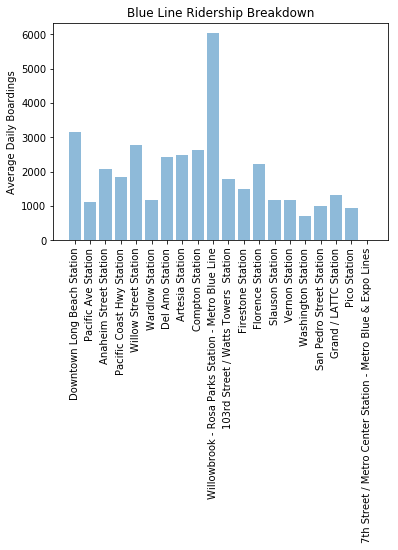

In [30]:
y_pos = np.arange(len(blue_ridership_df[0:20][["Station"]]))
stations = np.array(blue_ridership_df[0:20][["Station"]]).flatten()
boardings = np.array(blue_ridership_df[0:20][["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Blue Line Ridership Breakdown")


Collecting the dataframes from different lines and storing them into one list

In [0]:
line_ridership_df_list_17 = [blue_ridership_df, red_ridership_df, expo_ridership_df,
                      green_ridership_df, gold_ridership_df]

line_ridership_list_aggregated = []

for line_df in line_ridership_df_list_17:
  line_ridership_aggregated = {}
  invalid_row_indicies = []
  for i in range(len(line_df.index)):
    daily_boardings = line_df.loc[i]['Average_Daily_Boardings']
    daytype = line_df.loc[i]['Daytype']
    
    if type(line_df.loc[i]['Station']) is not str:
      invalid_row_indicies.append(i)
      
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
      
    elif daytype != "Weekday":
      invalid_row_indicies.append(i)     
      
  line_df.drop(invalid_row_indicies, inplace=True)
  line_ridership_list_aggregated.append(line_ridership_aggregated)
 
  

Visualizing ridership breakdown for each row!

Text(0.5, 1.0, 'Red Line Ridership Breakdown')

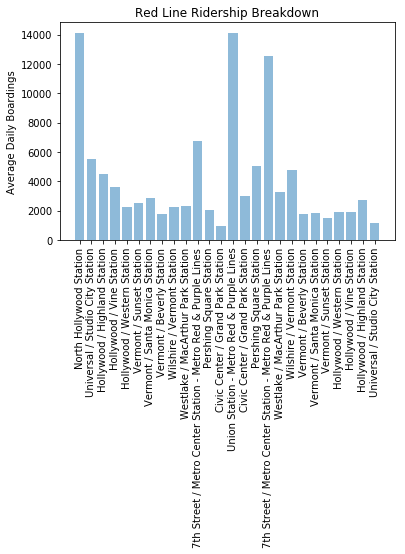

In [8]:
y_pos = np.arange(len(red_ridership_df[["Station"]]))
stations = np.array(red_ridership_df[["Station"]]).flatten()
boardings = np.array(red_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Red Line Ridership Breakdown")

Text(0.5, 1.0, 'Expo Line Ridership Breakdown')

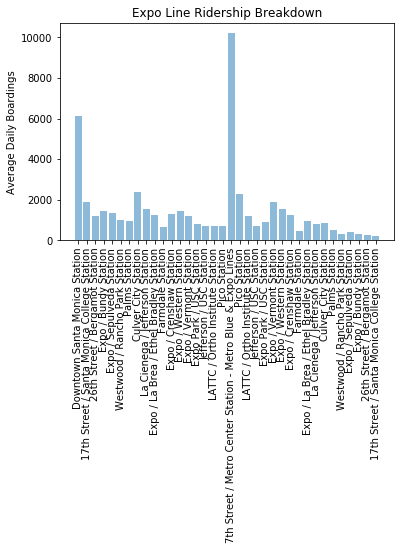

In [9]:
y_pos = np.arange(len(expo_ridership_df[["Station"]]))
stations = np.array(expo_ridership_df[["Station"]]).flatten()
boardings = np.array(expo_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Expo Line Ridership Breakdown")

By looking at the data, we can observe that some rows have empty values for stations and zero/NaN values for daily boardings. To clean up our data, we want to remove these rows from our dataframes. Here is a function that helps us with the removal.

In [0]:
def invalid_rows_to_remove(df):
  invalid_row_indicies = []
  for i in range(len(df.index)):
    station = df.loc[i]['Station']
    daily_boardings = df.loc[i]['Daily Boardings']
    if type(station) is not str:
      invalid_row_indicies.append(i)
  
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
  
  return invalid_row_indicies

## Extracting information from Older Metro Excel 

Since the data format for older metro ridership information is different, we need to do more data cleaning in order to read in the data.

In [0]:
blue_ridership_14_df = pd.read_excel("RailActivityByStationFY2014.xls", sheet_name="Blue Line", skiprows=6, skipcols=3, header=None)
#movies_skip_rows.columns = ['Title', 'Year', 'Genres
blue_ridership_14_df.columns = ["Temp1", "Temp2", "Temp3", "Station", "Daily Boardings", "Daily Alightings",
                                "Yearly Boardings", "Yearly Alightings", "Stop", 
                                "Latitude", "Longitude"]
blue_ridership_14_df.drop(columns=["Temp1", "Temp2", "Temp3"], inplace=True)

invalid_row_indicies = invalid_rows_to_remove(blue_ridership_14_df)

print(invalid_row_indicies)
blue_ridership_14_df.drop(invalid_row_indicies, inplace=True)
print(blue_ridership_14_df)

[20, 21, 43, 44, 45, 46, 67, 68, 90, 91, 92, 93, 114, 115]
                   Station  Daily Boardings  Daily Alightings  \
0             TRANSIT MALL      3647.283863               NaN   
1                  PACIFIC      1402.007093        272.830833   
2                  ANAHEIM      2586.072773        484.277785   
3    PACIFIC COAST HIGHWAY      2189.167504        762.143968   
4                   WILLOW      2751.614156        760.174282   
5                  WARDLOW      1192.517607        498.025956   
6                  DEL AMO      2386.285066        737.326554   
7                  ARTESIA      2878.997917       1201.076433   
8                  COMPTON      3116.408947       1609.272542   
9      IMPERIAL/WILMINGTON      6588.139024       4425.500295   
10            103RD STREET      2099.689913       1549.189499   
11               FIRESTONE      1736.899327       1393.357145   
12                FLORENCE      2622.312821       2233.471536   
13                 SLAUSON     

The spreadsheets before 2014 are also different from 2014, so we need to read the file slightly differently.

In [0]:
blue_ridership_13_df = pd.read_excel("RailActivityByStationFY2013.xls", sheet_name="Red Line", skiprows=6, skipcols=3, header=None)
blue_ridership_13_df.columns = ["Temp1", "Temp2", "Temp3", "Station", 
                                "Daily Boardings", "Daily Alightings",
                                "Yearly Boardings", "Yearly Alightings", "Temp4"]
blue_ridership_13_df.drop(columns=["Temp1", "Temp2", "Temp3", "Temp4"], inplace=True)
    
invalid_row_indicies = invalid_rows_to_remove(blue_ridership_13_df)

blue_ridership_13_df.drop(invalid_row_indicies, inplace=True)
blue_ridership_13_df.head(24)

[13, 14, 15, 29, 30, 31, 32, 33, 34, 48, 49, 50, 64, 65, 66, 67, 68, 69, 83, 84, 85, 99]
[13, 14, 15, 29, 30, 31, 32, 33, 34, 48, 49, 50, 64, 65, 66, 67, 68, 69, 83, 84, 85, 99]


,Station,Daily Boardings,Daily Alightings,Yearly Boardings,Yearly Alightings
0,NORTH HOLLYWOOD,17043.498268,NaN,4.329049e+06,NaN
1,UNIVERSAL CITY,5841.520020,992.836616,1.483746e+06,2.521805e+05
2,HOLLYWOOD/HIGHLAND,5166.162485,3417.522140,1.312205e+06,8.680506e+05
3,HOLLYWOOD/VINE,3919.211729,2039.924896,9.954798e+05,5.181409e+05
4,HOLLYWOOD/WESTERN,2702.026266,2428.943284,6.863147e+05,6.169516e+05
5,VERMONT/SUNSET,2936.654699,1927.920659,7.459103e+05,4.896918e+05
6,VERMONT/SANTA MONICA,3279.945400,2207.323958,8.331061e+05,5.606603e+05
7,VERMONT/BEVERLY,2296.842346,2018.096703,5.833980e+05,5.125966e+05
8,WILSHIRE/VERMONT,2474.770530,4732.090484,6.285917e+05,1.201951e+06
9,WESTLAKE,2198.559728,3270.661206,5.584342e+05,8.307479e+05


## Visualizing Metro Data

Using Matplotlib to visualize data

Text(0.5, 1.0, 'Blue Line Ridership Breakdown')

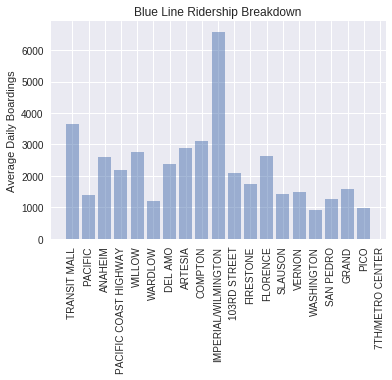

In [0]:
y_pos = np.arange(len(blue_ridership_14_df[0:20][["Station"]]))
stations = np.array(blue_ridership_14_df[0:20][["Station"]]).flatten()
boardings = np.array(blue_ridership_14_df[0:20][["Daily Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Blue Line Ridership Breakdown")

Displays keys of the dictionary

In [0]:
# Our collection of data on ridership data in a 2D Array
ridership_by_year = []

# lines_2010 = ["Blue Line", 
#               "Red Line", 
#               "Purple Line", 
#               "Green Line", 
#               "Gold Line, before East L A extn",
#               "Gold Line, after East L A extn"]

# ridership_df_list = []
# for line in lines_2010:
#     print("Entering ", line)
#     line_ridership_2010_df = pd.read_excel("RailActivityByStationFY2010.xls", sheet_name=line, skiprows=6, skipcols=3, header=None)
#     if line == "Red Line" or line == "Purple Line":
#       line_ridership_2010_df.columns = ["Temp1", "Temp2", "Temp3", "Station", 
#                                 "Daily Boardings", "Daily Alightings",
#                                 "Yearly Boardings", "Yearly Alightings"]
# #       line_ridership_df.drop(columns=["Temp1", "Temp2", "Temp3", "Temp4"], inplace=True)
#     else: # Non-red and non-purple line
#       line_ridership_2010_df.columns = ["Temp1", "Temp2", "Temp3", "Station", 
#                                 "Daily Boardings", "Daily Alightings",
#                                 "Yearly Boardings", "Yearly Alightings"]
# #       line_ridership_df.drop(columns=["Temp1", "Temp2", "Temp3", "Temp4"], inplace=True)
#     ridership_df_list.append(line_ridership_2010_df)
#     print(line)
    
# ridership_by_year.append(ridership_df_list)

filenames = [
             "RailActivityByStationFY2011.xls",
             "RailActivityByStationFY2012.xls",
             "RailActivityByStationFY2013.xls",
#              "RailActivityByStationFY2014.xls"
            ]

# Excluded Expo Line because Expo was added only starting from 2013
default_lines = ["Blue Line", "Red Line", "Purple Line", "Green Line", "Gold Line"]

# Iterating through every file, each file having data for a specified year 
for filename in filenames:
  print(filename)
  ridership_df_list = []
  # Storing information about each line in a dataframe and append to a list
  for line in default_lines:
    print(line)
    line_ridership_df = pd.read_excel(filename, sheet_name=line, skiprows=6, skipcols=3, header=None)
    if filename != "RailActivityByStationFY2014.xls" and (line == "Red Line" or line == "Purple Line"):
      line_ridership_df.columns = ["Temp1", "Temp2", "Temp3", "Station", 
                                "Daily Boardings", "Daily Alightings",
                                "Yearly Boardings", "Yearly Alightings", "Temp4"]
      line_ridership_df.drop(columns=["Temp1", "Temp2", "Temp3", "Temp4"], inplace=True)
    else: # Non-red and non-purple line
      line_ridership_df.columns = ["Temp1", "Temp2", "Temp3", "Station", 
                                "Daily Boardings", "Daily Alightings",
                                "Yearly Boardings", "Yearly Alightings"]
      line_ridership_df.drop(columns=["Temp1", "Temp2", "Temp3"], inplace=True)
    
    invalid_row_indicies = invalid_rows_to_remove(line_ridership_df)
    line_ridership_df.drop(invalid_row_indicies, inplace=True)
    print(line_ridership_df)
    ridership_df_list.append(line_ridership_df)
    
  ridership_by_year.append(ridership_df_list)
 
    
    
  

## Spatial Indexing

We can identify which metro stations belong to which census tract using Rtree's spatial indexing

In [0]:
# initialize rtree spatial index
tract_index = rtree.index.Index()

**Shapefile and Census data mapped across tracts**

In [10]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [11]:
import os
os.listdir("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/")

['tl_2018_06_tract.shx',
 'tl_2018_06_tract.prj',
 'tl_2018_06_tract.shp.iso.xml',
 'tl_2018_06_tract.cpg',
 'tl_2018_06_tract.dbf',
 'tl_2018_06_tract.shp.ea.iso.xml',
 'tl_2018_06_tract.shp']

Looking at the properties of census tracts we are interested in

In [12]:
                                                                                                                                                                          
# open shapefile with fiona                                                                                                                                                                                 
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
      # get first item in shape iterator                                                                                                                                                                    
      it = iter(f)                                                                                                                                                                                          
      example_data = next(it)                                                                                                                                                                               
      print("fiona parsed us an object of type:", type(example_data))                                                                                                                                       
                                                                                                                                                                                                            
print("Keys specifying shape info", example_data.keys())                                                                                                                                                    
                                                                                                                                                                                                            
print("keys:", example_data["geometry"].keys())                                                                                                                                                             
print("coordinates:", example_data["geometry"]["coordinates"])                                                                                                                                              
max_coord = max(example_data["geometry"]["coordinates"])                                                                                                                                                    
min_coord = min(example_data["geometry"]["coordinates"])                                                                                                                                                    
                                                                                                                                                                                                            
print("type:", example_data["geometry"]["type"])                                                                                                                                                            
                                                                                                                                                                                                            
print("keys:", example_data["properties"].keys())                                                                                                                                                           
for k in example_data["properties"].keys():                                                                                                                                                                 
      print(example_data["properties"][k])                                                                                                                                                                  
                                                                                                                                                                                                            
print("geoid:", example_data["properties"]["GEOID"])                                                                                                                                                        


fiona parsed us an object of type: <class 'dict'>
Keys specifying shape info dict_keys(['type', 'id', 'properties', 'geometry'])
keys: dict_keys(['type', 'coordinates'])
coordinates: [[(-118.581186, 34.143176), (-118.580994, 34.143341), (-118.580899, 34.143571), (-118.580927, 34.143786), (-118.580891, 34.144047), (-118.58094, 34.14423), (-118.580847, 34.14443), (-118.580915, 34.144628), (-118.580912, 34.144997), (-118.580214, 34.145547), (-118.580124, 34.145652999999996), (-118.580072, 34.145738), (-118.580036, 34.145829), (-118.580018, 34.145922999999996), (-118.580013, 34.146277999999995), (-118.579994, 34.147815), (-118.579988, 34.148282), (-118.57996800000001, 34.149885999999995), (-118.579955, 34.150079999999996), (-118.57983300000001, 34.151289), (-118.579702, 34.152585), (-118.579639, 34.153175), (-118.579521, 34.154343), (-118.579411, 34.155438), (-118.579311, 34.156435), (-118.579205, 34.157481), (-118.577684, 34.157498), (-118.577584, 34.157508), (-118.577427, 34.157536), (-1

Since we're interested only in census tracts in LA county, we will check each census tract shape item within the dataset and append it to our own data if it's in LA county, which means STATEFP is 6 (which is California) and COUNTYFP is 37 (which is Los Angeles County).

In [0]:
la_shapes = list()                                                                                                                                                                                          
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
     # print("orig len", len(f))                                                                                                                                                                             
      for shape in f:                                                                                                                                                                                       
            if shape["properties"]["STATEFP"]=='06' and shape["properties"]["COUNTYFP"]=='037':                                                                                                             
                  la_shapes.append(shape)      


Now that we have the shape files for each census tract in LA county, we want to map census tract data to the geographical shape file that we extracted above.

In [14]:
census_tract_data = {}                                                                                                                                                                                      
# open the census data for reading                                                                                                                                                                          
with open("/gdrive/Team Drives/CSCI499 Final Proj /new.csv", "r") as f: # awful filename                                                                                                                                                
  # parse out header                                                                                                                                                                                    
  p = f.readline().replace(","," ").split()                                                                                                                                                             
  print('p1', p)                                                                                                                                                                                        
                                                                                                               
  header = p                                                                                                                                                                                            
  f.readline()                                                                                                                                                                                          
# iterate over remaining lines                                                                                                                                                                        
  for line in f:                                                                                                                                                                                                                                                                                                                                            

      compos = [-1] # compos stores the positions of the relevant commas in the argument string                                                                                                       
      compos.extend(t[2][1] for t in generate_tokens(StringIO(line).readline) if t[1] == ',')                                                                                                         
      compos.append(len(line))                                                                                                                                                                        
      parts = [ line[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]                                                                                                                         
                                                                                                                                                             
      assert len(header) == len(parts)                                                                                                                                                                
      # create dictionary tracking data                                                                                                                                                               
      line = dict(zip(header, parts))                                                                                                                                                                 
      #print(line)                                                                                                                                                                                     
      # add to file using FIPS name                                                                                                                                                                                                                                                                                                                                          
      census_tract_data[line['Geo_TRACT']] = line                                                                                                                                                     


print(header)                                                                                                                                                                                               

la_shapes_ids = map(lambda x:x[0], la_shapes)  

p1 ['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY', 'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITSCE', 'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI', 'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_UACP', 'Geo_CDCURR', 'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD', 'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PUMA5', 'Geo_PUMA1', 'SE_A00001_001', 'SE_A00002_001', 'SE_A00002_002', 'SE_A00002_003', 'SE_A02001_001', 'SE_A02001_002', 'SE_A02001_003', 'SE_A01001_001', 'SE_A01001_002', 'SE_A01001_003', 'SE_A01001_004', 'SE_A01001_005', 'SE_A01001_006', 'SE_A01001_007', 'SE_A01001_008', 'SE_A01001_009', 'SE_A0

Here we're defining the radius we're using to determine the census tract information we're using based on whether or not a census tract falls within a metro station's defined radius. You can change this radius value to see different prediction values.

In [0]:
FACTOR = 68.75                                                                                                                                                                                        
RADIUS = 1.5


Here we define the function that returns all the traffic counts based on a given latitude and longitude (a location point).

In [0]:
def getNearbyTrafficIntersections(lat, lon):
  lat = lat*FACTOR                                                                                                                                                                                      
  lon = lon*FACTOR                                                                                                                                                                                      
  
  nearbyIntersections = list()
  
  traffic_df = pd.read_csv("/gdrive/Team Drives/CSCI499 Final Proj /LADOT_Traffic_Counts_Summary_w_latLong.csv")
  #print(traffic_df.head())
  
  for index, row in traffic_df.iterrows():
    curr_lat = float(row["LAT"])*FACTOR
    curr_lon = float(row["LONG"])*FACTOR
    if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=RADIUS:
      print(row["Total"])
      nearbyIntersections.append(row["Total"])
  
  return nearbyIntersections

# Function that takes lat, long and returns list of census 
# tracts near station
def getNearbyCensusTracts(lat, lon):                                                                                                                                                                        
                                                                                                                                                                                                
      lat = lat*FACTOR                                                                                                                                                                                      
      lon = lon*FACTOR                                                                                                                                                                                      
                                                                                                                                                                                                            
      nearby_shapes = list()                                                                                                                                                                                
                                                                                                                                                                                                            
      for s in la_shapes:                                                                                                                                                                                   
            curr_lat = float(s["properties"]["INTPTLAT"])*FACTOR                                                                                                                                            
            curr_lon = float(s["properties"]["INTPTLON"])*FACTOR                                                                                                                                            
            if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=RADIUS:
            #if abs(lat-curr_lat)<=RADIUS and abs(lon-curr_lon)<=RADIUS:                                                                                                                                     
#                  print("lat diff: ", abs(lat-curr_lat), " and long diff: ", abs(lon-curr_lon))                                                                                                            
 #                 print("lat:", curr_lat,  "long:", curr_lon)                                                                                                                                              
                  nearby_shapes.append(s)                  
      
      return nearby_shapes

Function 

## Creating Training Dataset

For each metro station, we draw a 2 mile radius: within that radius, we find which census tract belongs to that station and average the household income data and population density data, and also the number of traffic counts that's inside the tract. 

In [17]:
x_train = []
x_stations = []
for line_ridership_df in line_ridership_df_list_17:
  for index, row in line_ridership_df.iterrows():
    print(row["Station"])
    num_census_tracts = 0
    household_income_sum = 0
    population_density_sum = 0
    traffic_sum = 0
    (lat, long) = (row["Latitude"], row["Longitude"])
    print(lat, long)
    x_stations.append(row["Station"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    pop_densities = list()
    avg_household_incomes = list()



    for tract in nearby_tracts:
      tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
      #print("NUM: ", tract_num_key)

      pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
      pop_densities.append(pop_density)
      #print("PD:",pop_density)

      income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
      if income:
        avg_household_incomes.append(float(income))  
      #print("IN:",income)


    avg_pop_density = sum(pop_densities)/len(pop_densities)
    avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

    x_train.append([avg_pop_density,avg_household_income])
    #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)
  
  

Downtown Long Beach Station
33.768071 -118.192921
Pacific Ave Station
33.772258 -118.1937
Anaheim Street Station
33.78183 -118.189384
Pacific Coast Hwy Station
33.78909 -118.189382
Willow Street Station
33.807079 -118.189834
Wardlow Station
33.819865 -118.19609
Del Amo Station
33.848222 -118.211017
Artesia Station
33.876082 -118.222503
Compton Station
33.89749 -118.224249
Willowbrook - Rosa Parks Station - Metro Blue Line
33.928048 -118.237555
103rd Street / Watts Towers  Station
33.94222 -118.243159
Firestone Station
33.959611 -118.243205
Florence Station
33.97374 -118.243271
Slauson Station
33.98876 -118.243398
Vernon Station
34.00292 -118.243303
Washington Station
34.01965 -118.243084
San Pedro Street Station
34.026807 -118.255505
Grand / LATTC Station
34.033155 -118.269333
Pico Station
34.040735 -118.266118
7th Street / Metro Center Station - Metro Blue & Expo Lines
34.04861 -118.258822
Pico Station
34.040735 -118.266118
Grand / LATTC Station
34.033155 -118.269333
San Pedro Street 

Our Y_Train data is average ridership data for each metro station.

In [18]:
y_train = []

for line_ridership_df in line_ridership_df_list_17:
  for index, row in line_ridership_df.iterrows():
    y_train.append(row["Average_Daily_Boardings"])

  
y_train = np.array(y_train)

print(len(y_train))


179


Testing data: Purple Line

In [20]:
x_test = []
y_test = []
x_test_stations = []

purple_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Purple Line")

invalid_row_indicies = []
for i in range(len(purple_ridership_df.index)):
  daily_boardings = purple_ridership_df.loc[i]['Average_Daily_Boardings']
  daytype = purple_ridership_df.loc[i]['Daytype']

  if type(purple_ridership_df.loc[i]['Station']) is not str:
    invalid_row_indicies.append(i)

  elif daily_boardings == 0 or isnan(daily_boardings):
    invalid_row_indicies.append(i)

  elif daytype != "Weekday":
    invalid_row_indicies.append(i)

purple_ridership_df.drop(invalid_row_indicies, inplace=True)

  
# Purple Line
for index, row in purple_ridership_df.iterrows():
  print(row["Station"])
  num_census_tracts = 0
  household_income_sum = 0
  population_density_sum = 0
  traffic_sum = 0
  (lat, long) = (row["Latitude"], row["Longitude"])
  print(lat, long)
  x_test_stations.append(row["Station"])
  
  nearby_tracts = getNearbyCensusTracts(lat,long)
  
  pop_densities = list()
  avg_household_incomes = list()
  
                                                                                                                                                                              

  for tract in nearby_tracts:
    tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
    #print("NUM: ", tract_num_key)
    
    pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
    pop_densities.append(pop_density)
    #print("PD:",pop_density)
    
    income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
    if income:
      avg_household_incomes.append(float(income))  
    #print("IN:",income)
    
   
    
    
  avg_pop_density = sum(pop_densities)/len(pop_densities)
  avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)
  
  x_test.append([avg_pop_density,avg_household_income])
    #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)
  


# Purple Line
for index, row in purple_ridership_df.iterrows():
  
  # Adding average daily boardings into y_test
  y_test.append(row["Average_Daily_Boardings"])


x_test = np.array(x_test)
y_test = np.array(y_test)


Wilshire / Western Station
34.061689 -118.308756
Wilshire / Normandie Station
34.061753 -118.301458
Wilshire / Vermont Station
34.062701 -118.290082
Westlake / MacArthur Park Station
34.056368 -118.274879
7th Street / Metro Center Station - Metro Red & Purple Lines
34.048634 -118.258682
Pershing Square Station
34.049316 -118.251259
Civic Center / Grand Park Station
34.0549 -118.246057
Union Station - Metro Red & Purple Lines
34.056197 -118.234249
Civic Center / Grand Park Station
34.0549 -118.246057
Pershing Square Station
34.049316 -118.251259
7th Street / Metro Center Station - Metro Red & Purple Lines
34.048634 -118.258682
Westlake / MacArthur Park Station
34.056368 -118.274879
Wilshire / Vermont Station
34.062701 -118.290082
Wilshire / Normandie Station
34.061753 -118.301458


## Creating Machine Learning Model

Import Python packages for Linear Regression and XG Boost

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics
import xgboost as xgb

In [22]:
np.set_printoptions(threshold=sys.maxsize)

print(x_train)
#x_train.shape
#y_train.reshape(405,1)
#y_train.shape

[[29238.701470588236, 53234.892841509274], [29388.740789473686, 52617.638260478205], [27514.422407407408, 53021.521846850104], [26298.56766666667, 52093.43382300369], [16160.191, 69568.18200511091], [8624.8327, 94622.56741498929], [11642.345375, 78435.17166345842], [11140.410375, 58598.4565150056], [15042.7933125, 54370.71113125301], [17333.113529411763, 48972.55929493185], [19319.8101, 44329.34602709424], [20060.727407407412, 46198.02488332338], [19599.82861538462, 46640.16803471407], [20725.279090909098, 45401.77703090721], [21933.899444444447, 43592.01462044609], [19514.826624999998, 46078.57329244295], [19733.5508, 50080.70930911324], [24191.870827586208, 42591.39297306848], [37399.38397058824, 46794.6542592005], [36108.21747058823, 53594.08544744862], [37399.38397058824, 46794.6542592005], [24191.870827586208, 42591.39297306848], [19733.5508, 50080.70930911324], [19514.826624999998, 46078.57329244295], [21933.899444444447, 43592.01462044609], [20725.279090909098, 45401.77703090721

Instantiating the model and training the model

Linear Regression r^2: -0.6090262748211319
MSE r^2: 8050815.7782251015
14


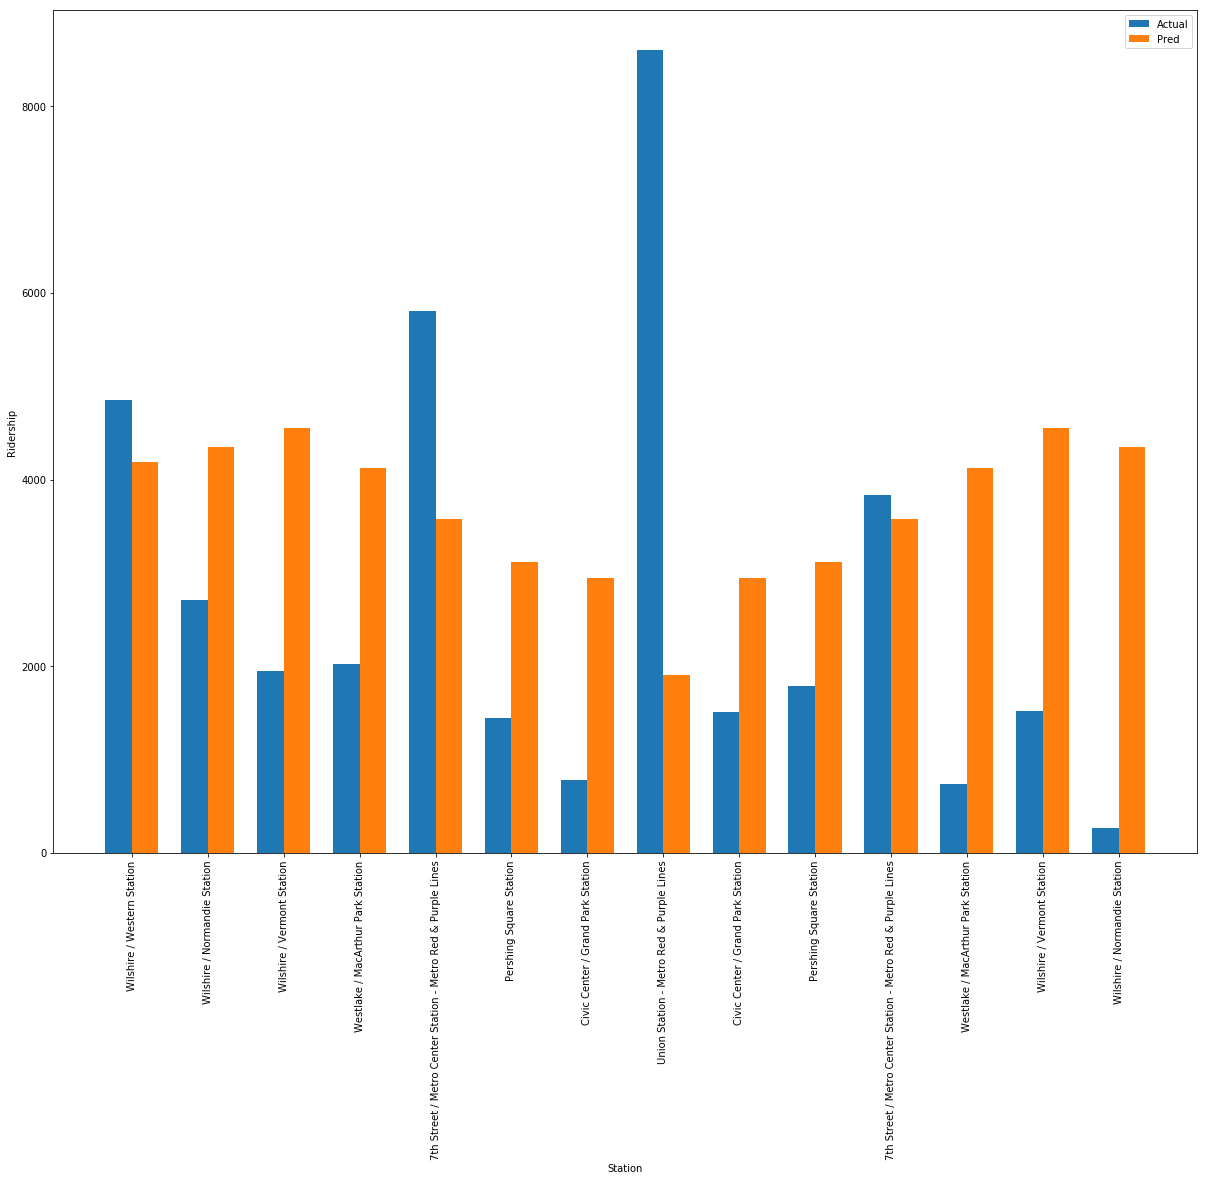

svr rbf r^2: 0.14736578466044925
MSE r^2: 4266183.281981097


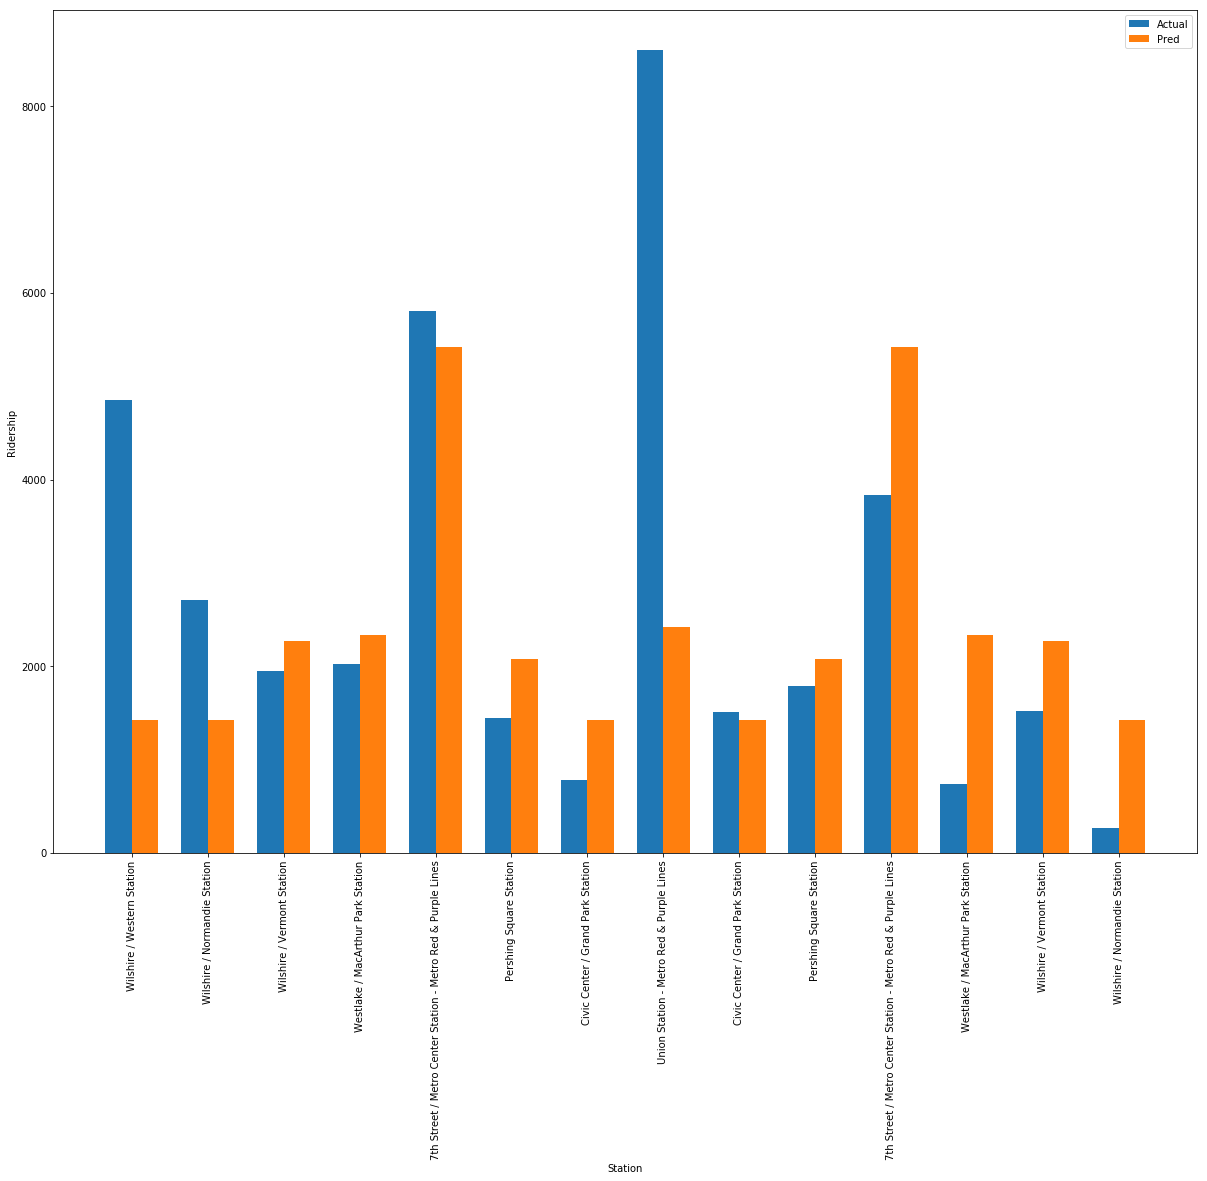

XGBoost r^2: -0.5722495461618742
MSE r^2: 7866802.209276782


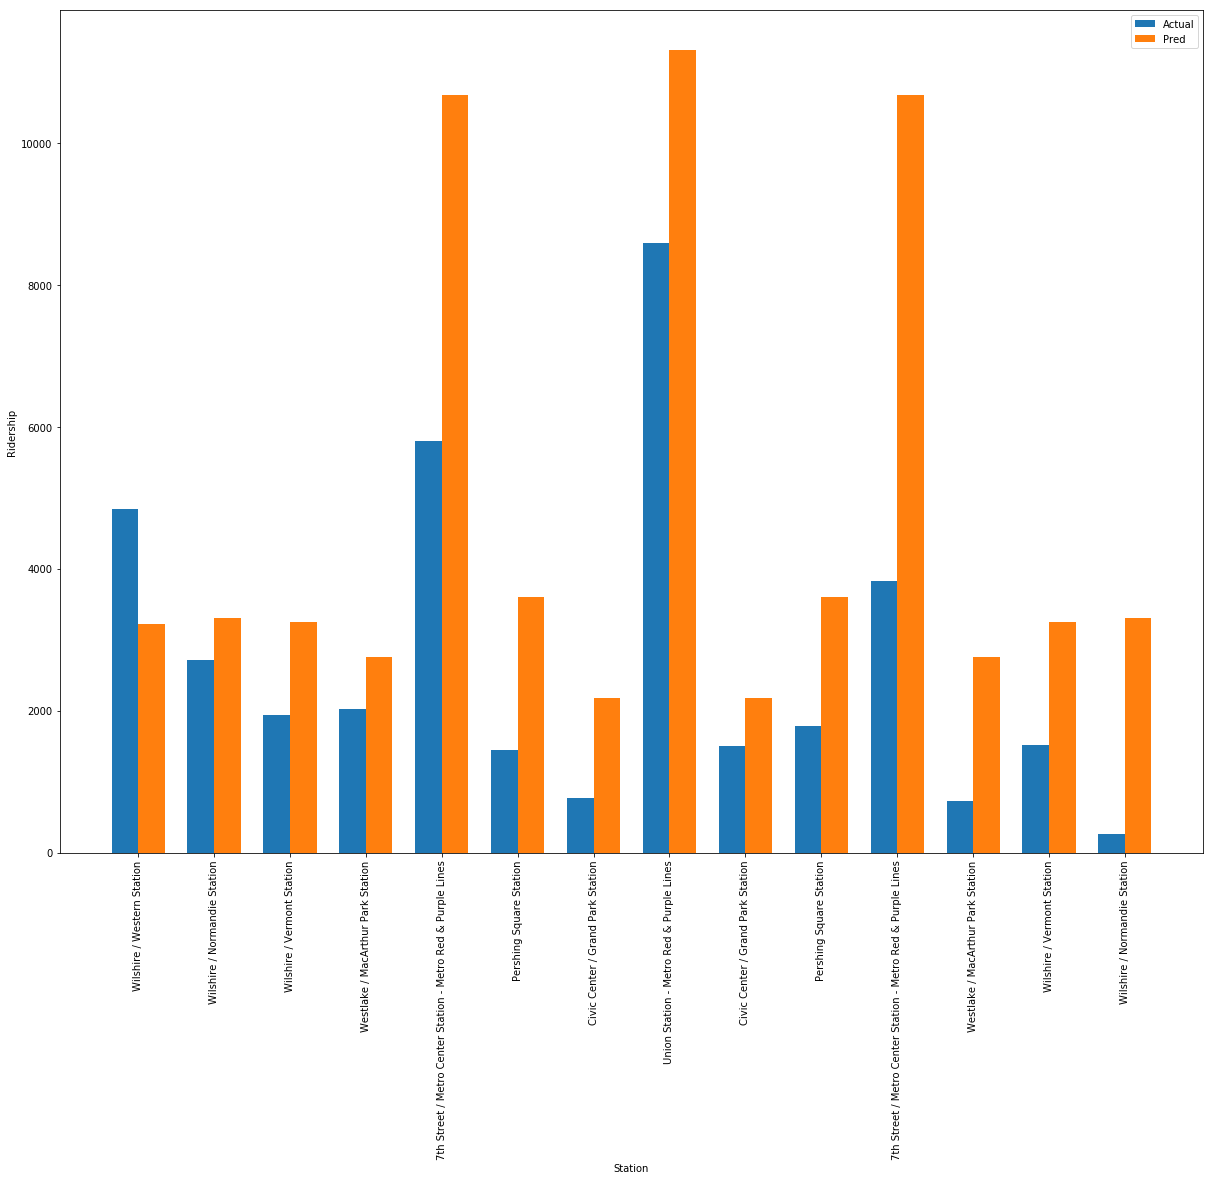

In [24]:


# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
 
print("Linear Regression r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))


fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
print(len(index))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(20.5, 15.5)
plt.show()

# Support Vector Regression
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

svr_rbf.fit(x_train,y_train)
y_pred = svr_rbf.predict(x_test)
print("svr rbf r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(20.5, 15.5)
plt.show()
'''
svr_lin.fit(x_train,y_train)
y_pred = svr_lin.predict(x_test)
print("svr lin r^2:",metrics.r2_score(y_test, y_pred))

svr_poly.fit(x_train,y_train)
y_pred = svr_poly.predict(x_test)
print("svr poly r^2:",metrics.r2_score(y_test, y_pred))
'''
# XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print("XGBoost r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))


fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(20.5, 15.5)
plt.show()
